## 多分类学习

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io    #用于加载 *.mat数据
import random
from scipy import optimize

In [3]:
datafile='data\ex3data1.mat'
data_matrix=scipy.io.loadmat(datafile)
X=np.array(data_matrix['X'])
y=np.array(data_matrix['y'])

In [4]:
m=X.shape[0] #样本数=5000
n=X.shape[1] #特征数=400
X=np.insert(X,0,1,axis=1)

print('The shape of X is {0}'.format(X.shape))
print('The shape of y is {0}, and unique elements in y: {1}'.format(y.shape,np.unique(y)))

The shape of X is (5000, 401)
The shape of y is (5000, 1), and unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]


In [5]:
def arr2Img(arr):
    '''
    输入一个1x400的数组，将之转化为20x20的图像并返回
    '''
    width,height=20,20
    img=arr[1:].reshape(width,height)
    return img.T

def plotData(data=None):
    '''
    从X中随机选取100行，将每行转化为20x20的图像，
    并按10x10将这些图像组合起来输出为一个大图
    '''
    width,height = 20,20
    row,col=10,10
    if not data:
        data=random.sample(range(m),row*col)
    
    full_img_mat=np.zeros((height*row,width*col))
    
    irow,icol=0,0
    for i in data:
        if icol==col: #到达一行的末尾
            irow+=1
            icol=0
        img_mat=arr2Img(X[i])
        #将img矩阵赋值给大图矩阵相应的位置
        full_img_mat[irow*height:irow*height+img_mat.shape[0],icol*width:icol*width+img_mat.shape[1]]=img_mat
        icol+=1
        
    plt.figure(figsize=(6,6))
    plt.imshow(full_img_mat,cmap='gray', extent=[-1, 1, -1, 1])

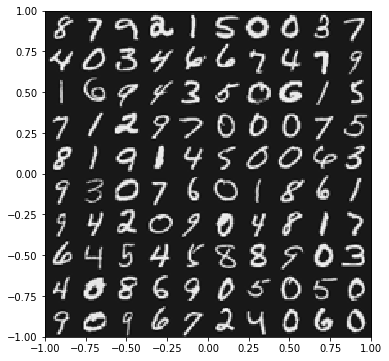

In [6]:
plotData()

In [7]:
def h(theta, X):
    return 1/(1+np.exp(-np.dot(X,theta)))

def cost(theta, X, y, mylambda):
    m = X.shape[0]
    pos = -np.dot(y.T, np.log(h(theta, X)))
    neg = -np.dot((1-y).T, np.log(1-h(theta, X)))
    reg = (mylambda/2)*np.dot(theta[1:].T, theta[1:])
    return float((1/m)*(pos+neg+reg))

In [8]:
def costGrad(theta, X, y, mylambda):
    m = X.shape[0]
    tmp = h(theta, X)-y
    reg = (mylambda/m)*theta[1:]
    grad = (1./m)*np.dot(X.T,tmp)
    grad[1:] = grad[1:] + reg
    return grad


def opt(theta, X, y, mylambda):
    '''
    这里求最优解时使用fmin_cg函数有一个问题，它的x0参数只接受一维数组，
    但显然我们的theta是一个多维数组，如果把theta降维之后再传递给fmin_cg，
    则又会导致调用h, cost, costGrad等函数时theta的维度与定义不合
    目前暂时没有解决方案
    '''
    result = optimize.fmin_cg(cost, fprime=costGrad, x0=theta, args=(X, y, mylambda), maxiter=50, disp=False)
    return result

In [9]:
def onevsall(theta, X, y, mylambda, K):
    for i in range(1, K+1):
        myy = np.array([[1] if yy[0]==i else [0] for yy in y])
        itheta = opt(theta.reshape(-1), X, myy, mylambda)
        all_theta[:,i-1:i] = itheta.reshape(x.shape[1],1)
        print('Build theta{0} complete!'.format(i))
    print('Done!')

In [10]:
K=10
theta_init = np.zeros(X.shape[1])
all_theta = np.zeros((K,X.shape[1]))

In [11]:
# 重写cost和costGrad函数
def cost_cg(theta, X, y, mylambda):
    theta_1 = theta.reshape(X.shape[1],1)
    m = X.shape[0]
    pos = -np.dot(y.T, np.log(h(theta_1, X)))
    neg = -np.dot((1-y).T, np.log(1-h(theta_1, X)))
    reg = (mylambda/2)*np.dot(theta_1[1:].T, theta_1[1:])
    return float((1/m)*(pos+neg+reg))

def costGrad_cg(theta, X, y, mylambda):
    theta_1 = theta.reshape(X.shape[1],1)
    m = X.shape[0]
    tmp = h(theta_1, X)-y
    reg = (mylambda/m)*theta_1[1:]
    grad = (1./m)*np.dot(X.T,tmp)
    grad[1:] = grad[1:] + reg
    return grad

In [12]:
def opt_cg(theta, X, y, mylambda):
    result = optimize.fmin_cg(cost_cg, fprime=costGrad_cg, x0=theta, args=(X, y, mylambda), maxiter=50, disp=False)
    return result

In [13]:
theta_t = np.array([-2, -1, 1, 2])
X_t = np.c_[np.ones(5), np.arange(1, 16).reshape((3, 5)).T/10]
y_t = np.array([1, 0, 1, 0, 1]).reshape((5,1))
print(cost_cg(theta_t,X_t,y_t,3))
print(costGrad_cg(theta_t,X_t,y_t,3))

2.5348193961097443
[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]


## 神经网络

In [14]:
weight_mat = scipy.io.loadmat('data\ex3weights.mat')
theta1 = weight_mat['Theta1']
theta2 = weight_mat['Theta2']

print(theta1.shape)
print(theta2.shape)

(25, 401)
(10, 26)


In [15]:
def predict(theta1, theta2, X):
    
    m = X.shape[0]
    
    # Used to store predicted value
    p = np.zeros(m)
    
    a1 = h(theta1.T, X)
    a1 = np.insert(a1, 0, 1, axis=1)
    a2 = h(theta2.T, a1)
    
    k = 0
    for i in a2:
        i_max = np.amax(i)
        p[k] = int(np.where(i == i_max)[0])+1
        k += 1
        
    return p.reshape(m, 1)

In [16]:
pred = predict(theta1, theta2, X)
print('Training set accuracy: {}%'.format(np.mean(pred == y)*100))

Training set accuracy: 97.52%


In [25]:
incorrect_indices = []
for i in range(m):
    if (pred[i] != y[i]):
        incorrect_indices.append(i)

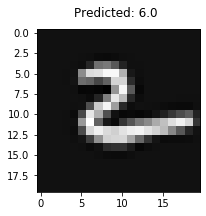

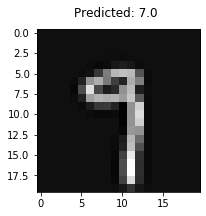

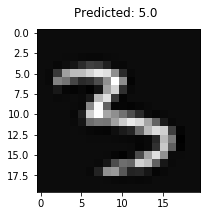

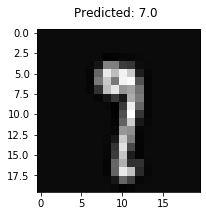

In [48]:
for x in range(4):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(3,3))
    img = arr2Img(X[i])
    plt.imshow(img,cmap='gray')
    fig.suptitle('Predicted: {0}'.format(pred[i,0]))